# Paper figures

This notebooks provides code to generate the figures presented in the paper. To do so, it relies on the processed cadastre dataset, as well as the solutions generated by A-DBSCAN for cities and employment centres.

In [1]:
%matplotlib inline

import tools, time, os, sys, traceback
from time import gmtime, strftime

import pandas
import geopandas
import numpy as np
import datashader as ds
from datashader import transfer_functions as tf

import matplotlib.pyplot as plt
from seaborn import palplot
import palettable as pltt
import contextily as cx

from sqlalchemy import create_engine
db_path = ('/home/jovyan/work/Dropbox/Cadastre/'\
           '01 Catastro maps/sqlite_db/cadastro.db')
engine = create_engine('sqlite:////'+db_path)

Global parameters:

In [2]:
YBOUND = 3980000
BGCOLOR = 'w'
CMAP = 'gist_gray'

## Load data (solution $\epsilon=2000$ and `min_pts`$=2000$

* Load point data

In [3]:
qry = """
SELECT X, Y, numberOfBuildingUnits, numberOfDwellings
FROM cadastro;
"""

%time db = pandas.read_sql(qry, engine)
db.head()

CPU times: user 31.3 s, sys: 7.14 s, total: 38.5 s
Wall time: 38.5 s


X             Y  numberOfBuildingUnits  numberOfDwellings
0  626131.901334  4.341458e+06                      1                  0
1  626225.672859  4.341405e+06                      1                  1
2  626241.150791  4.341401e+06                      1                  1
3  626307.282565  4.341552e+06                      1                  0
4  626183.665280  4.341338e+06                      1                  1

* Load solution data

First, results at the building level (labels):

In [4]:
p = "../output/revision/solution_rep1000_eps2000_mp2000_thr90.parquet"
solu = pandas.read_parquet(p)
solu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12069635 entries, 0 to 12069634
Data columns (total 3 columns):
id      int64
lbls    int64
pct     float64
dtypes: float64(1), int64(2)
memory usage: 368.3 MB


In [5]:
solu.head()

id  lbls    pct
0   0    -1  100.0
1   1    -1  100.0
2   2    -1  100.0
3   3    -1  100.0
4   4    -1  100.0

And the aggregated city boundaries:

In [6]:
p = '../output/revision/solution_rep1000_eps2000_mp2000_thr90.gpkg'
gdb = geopandas.read_file(p)
gdb = gdb[gdb.centroid.y > YBOUND]
gdb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 703 entries, 0 to 716
Data columns (total 3 columns):
lbls        703 non-null float64
n_pts       703 non-null int64
geometry    703 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 22.0+ KB


In [7]:
gdb.head()

lbls  n_pts                                           geometry
0   0.0   2348  POLYGON ((385390.0710362921 4202949.446049213,...
1   1.0   2741  POLYGON ((214893.0330817204 4579137.557892084,...
2   2.0   5472  POLYGON ((690674.2811495251 4182188.538191385,...
3   3.0  14608  POLYGON ((513378.2815176058 4072327.639169693,...
4   4.0   2324  POLYGON ((206989.0807250602 4129478.031122195,...

* Join

In [8]:
%%time
one_all = db.join(solu[['lbls']])

CPU times: user 816 ms, sys: 356 ms, total: 1.17 s
Wall time: 1.17 s


* Keep the peninsula only

In [9]:
one = one_all.loc[one_all['Y'] > YBOUND, :]

* Non-residential points

In [10]:
emp = one_all['numberOfBuildingUnits'] - \
      one_all['numberOfDwellings']
emp = pandas.DataFrame({'emp': emp[emp > 0]})\
            .join(one_all)
emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395386 entries, 0 to 12069620
Data columns (total 6 columns):
emp                      int64
X                        float64
Y                        float64
numberOfBuildingUnits    int64
numberOfDwellings        int64
lbls                     int64
dtypes: float64(2), int64(4)
memory usage: 394.7 MB


In [11]:
emp.head()

emp              X             Y  numberOfBuildingUnits  numberOfDwellings  \
0    1  626131.901334  4.341458e+06                      1                  0   
3    1  626307.282565  4.341552e+06                      1                  0   
5    1  626250.669305  4.341426e+06                      1                  0   
6    1  625972.304467  4.341464e+06                      1                  0   
7    1  626522.307246  4.341544e+06                      1                  0   

   lbls  
0    -1  
3    -1  
5    -1  
6    -1  
7    -1

* Keep only non-residential in the peninsula

In [12]:
emp_pen = emp.loc[emp['Y'] > YBOUND, :]

## Figures

### Spain buildings (*Fig. 1*)

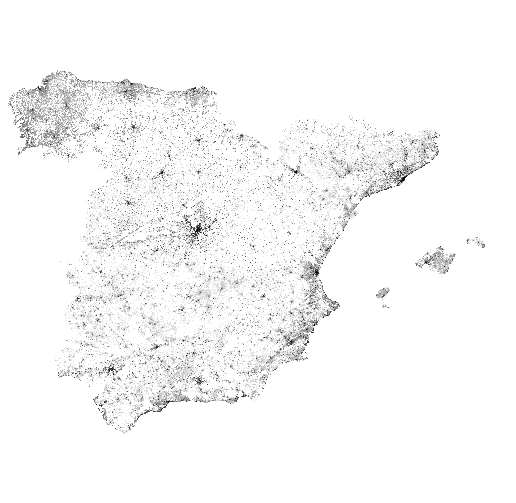

In [13]:
# datashader
cvs = ds.Canvas(plot_width=1920, plot_height=1080)
agg = cvs.points(one, 'X', 'Y', ds.sum('numberOfBuildingUnits'))
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], 
               how='log')
# numpy
a = np.flipud(img.values.astype(float))
mask = np.where(a==0)
a[mask] = np.nan
# matplotlib
ext = one[['X', 'Y']].describe()\
                          .loc[['min', 'max'], :]\
                          .T\
                          .stack()\
                          .values
f, ax = plt.subplots(1, figsize=(9, 9))
f.set_facecolor(BGCOLOR)
ax.imshow(a, cmap=CMAP, extent=ext)
ax.set_facecolor(BGCOLOR)
ax.set_axis_off()
ax.axis('equal')

plt.savefig('figures/revision/fig2.png', facecolor=BGCOLOR, dpi=900)
plt.show()

### Spain cities (*Fig. 5*)

In [14]:
city = pandas.Categorical(one['lbls'] == -1)

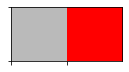

In [15]:
clrs = ['#bababa', '#ff0000']
palplot(clrs)

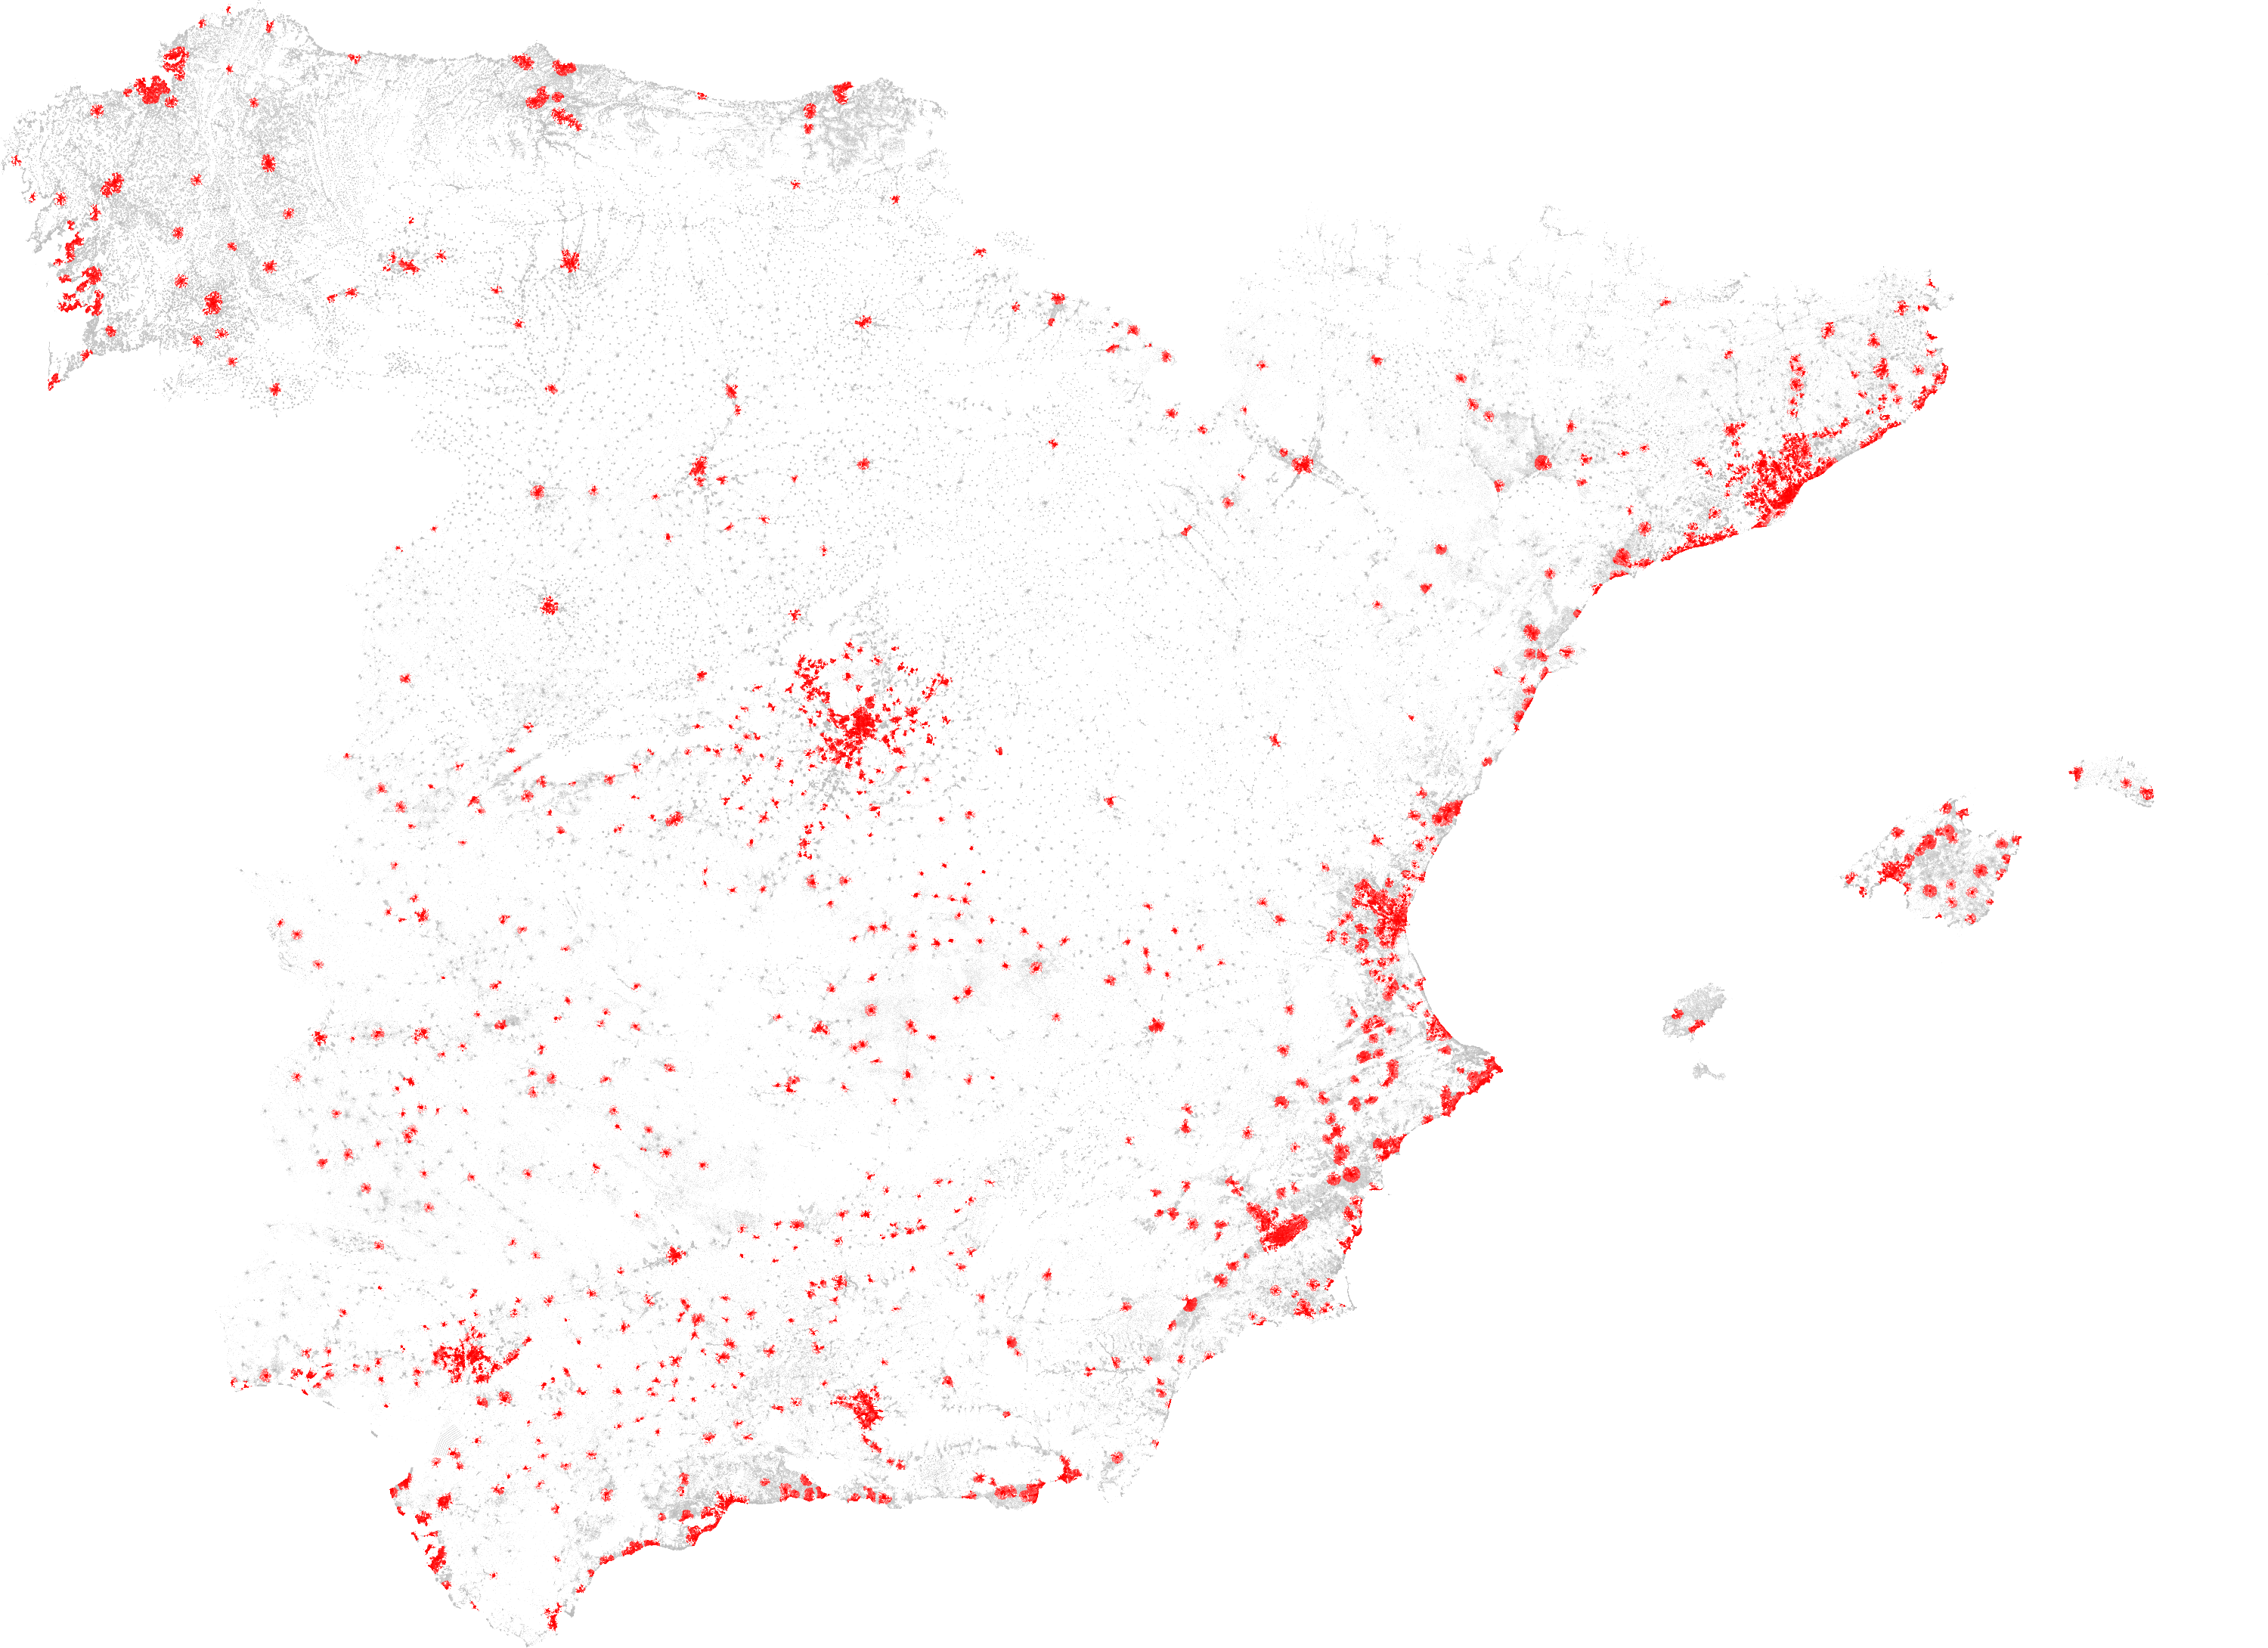

In [16]:
# Keep ratio
bb = one[['X', 'Y']].describe().T[['min', 'max']]
xd, yd = bb['max'] - bb['min']

# datashader
width = 3000
cvs = ds.Canvas(plot_width=width, plot_height=int(width*yd/xd))
agg = cvs.points(one.assign(city=city), 
                 'X', 'Y', ds.count_cat('city'))
img = tf.shade(agg, color_key={True: clrs[0],
                               False: clrs[1]}, 
               how='eq_hist')

img.to_pil().save('figures/revision/fig5.png')
img

### Barcelona region (*Fig. 6*)

In [17]:
bcn_bbox = [862150, 4513979, 1008389, 4674258]

bcn = one.loc[(bcn_bbox[0] < one['X']) & 
              (bcn_bbox[2] > one['X']) &
              (bcn_bbox[1] < one['Y']) & 
              (bcn_bbox[3] > one['Y'])
              , :]


In [18]:
def plot_region(bbox, pts, boundaries=None, name=None,
                cmap=CMAP, boundary_color='#7570b3',
                bgcolor=BGCOLOR, saveto=None):
    f, ax = plt.subplots(1, figsize=(9, 9), facecolor=bgcolor)

    reg = one.loc[(bbox[0] < one['X']) & 
              (bbox[2] > one['X']) &
              (bbox[1] < one['Y']) & 
              (bbox[3] > one['Y'])
              , :]
    tools.shade_pts(reg[['X', 'Y']], cmap=cmap,
                    w=900, h=900,
                    ax=ax, alpha=1)
    if boundaries is not None:
        minX, minY, maxX, maxY = bbox
        cts = boundaries.centroid
        area_boundaries = boundaries.loc[(cts.x > minX) &
                                         (cts.x < maxX) &
                                         (cts.y > minY) &
                                         (cts.y < maxY)]
        area_boundaries.boundary.plot(ax=ax, 
                                      color=boundary_color, 
                                      linewidth=1)
    if name:
        ax.set_title(name, color='k', fontsize=20,
                     bbox={'facecolor':'w', 'alpha':0.5, 'pad':1,
                           'edgecolor': 'w'})
    ax.axis('equal')
    ax.set_axis_off()
    ax.set_facecolor(bgcolor)
    
    if saveto:
        plt.savefig(saveto, dpi=900, facecolor=bgcolor)

    return f, ax

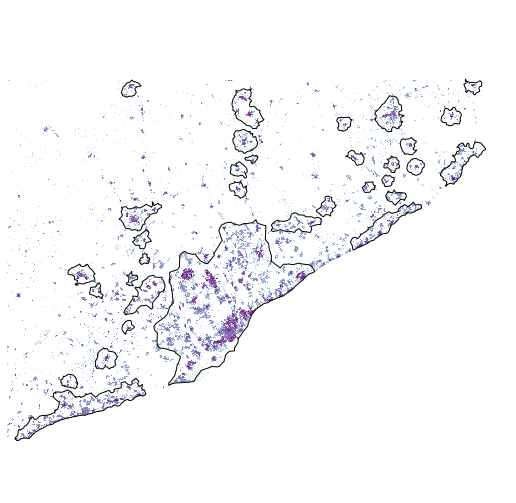

In [19]:
plot_region(bcn_bbox, bcn, boundaries=gdb, name=None,
            cmap='BuPu_r', bgcolor='w', boundary_color='k',
            saveto='figures/revision/fig6.png');

### Barcelona city employment centres (*Fig. 7*)

In [20]:
p = '../output/revision/rep1000_mp2000_eps2000_centres_adbscan.gpkg'
empc = geopandas.read_file(p)

In [21]:
def plot_city(city_id, pts, cities, centres, name=None,
              cmap=CMAP, bgcolor=BGCOLOR, 
              city_boundary_color='#7570b3', centre_boundary_color='red',
              saveto=None):
    f, ax = plt.subplots(1, figsize=(9, 9), facecolor=bgcolor)
    
    city = cities.loc[cities['lbls']==city_id, :]
    # Shade buildings
    city_pts = pts.loc[pts['lbls']==city_id, :]
    tools.shade_pts(city_pts[['X', 'Y', 'numberOfBuildingUnits']],
                    z='numberOfBuildingUnits',
                    w=900, h=900,
                    cmap=cmap, ax=ax, alpha=1)
    # Draw city boundary
    city.boundary.plot(ax=ax, 
                       color=city_boundary_color, 
                       linewidth=1)
    # Draw centres
    centres_city = centres.loc[centres['city_id']==city_id, :]
    centres_city.boundary.plot(ax=ax,
                               color=centre_boundary_color)
    # Other
    if name:
        ax.set_title(name, color='k', fontsize=20,
                     bbox={'facecolor':'w', 'alpha':0.5, 'pad':1,
                           'edgecolor': 'w'})
    ax.axis('equal')
    ax.set_axis_off()
    ax.set_facecolor(bgcolor)
    
    if saveto:
        plt.savefig(saveto, dpi=500, facecolor=bgcolor)

    return f, ax

* All centres

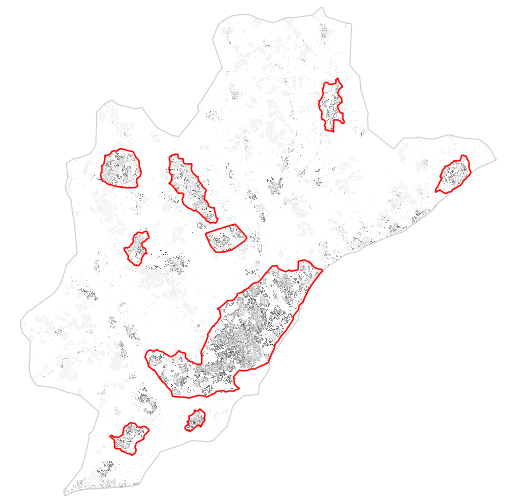

In [22]:
plot_city(15, one, gdb, 
          empc.query("city_id == 15")\
              .sort_values("n_pts", ascending=False)\
              .head(9),
          bgcolor='w', cmap='Greys_r', 
          city_boundary_color='0.8', 
          centre_boundary_color='#ff0000',
          name=None,
          saveto='figures/revision/fig7.png');

#### Appendix-B: Parameter sensibility (Spain)

In [23]:
def reader(f):
    db = pd.read_feather(p+f)
    l = np.array([f.strip('sp_').strip('.feather')]*2)
    db.columns = pd.MultiIndex.from_arrays([l, db.columns])
    return db

def eps_mp2f(eps, mp):
    f = 'sp_mp%i_eps%s.gpkg'%(mp, eps)
    return f

epss = [1500, 1600, 1800, None, 2000, None, 2200, 2400, 2500]
min_pts = 2000

p = '../output/'

CPU times: user 13.7 s, sys: 5.81 s, total: 19.5 s
Wall time: 19 s


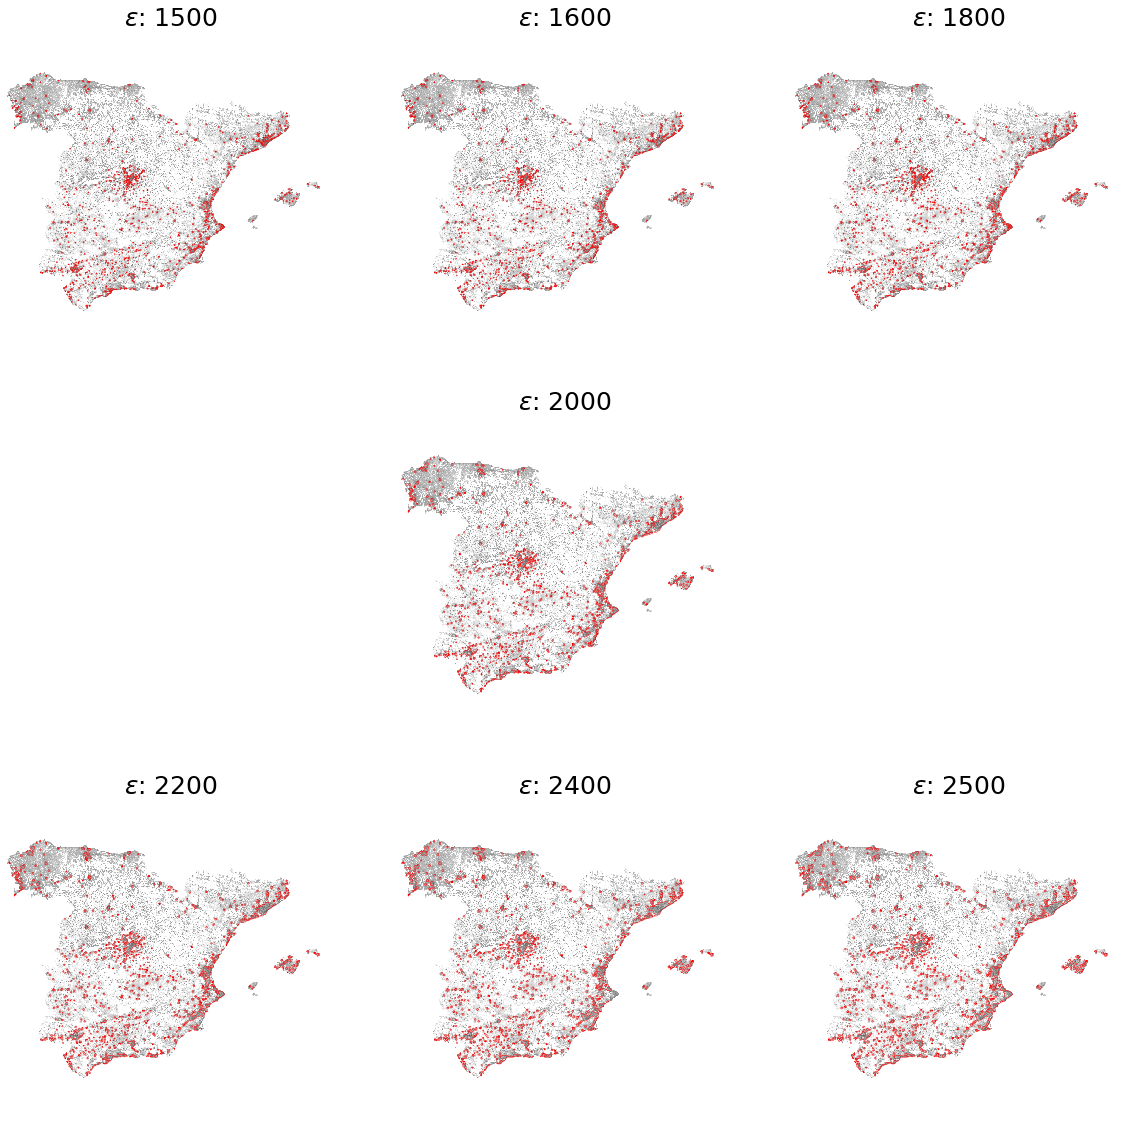

In [24]:
%%time

f, axs = plt.subplots(3, 3, figsize=(20, 20))
f.set_facecolor(BGCOLOR)
axs = axs.flatten()

for i in range(9):
    eps = epss[i]
    url = p + eps_mp2f(eps, min_pts)
    ax = axs[i]
    if eps:
        try:
            gdb = geopandas.read_file(url)
            gdb = gdb[gdb.centroid.y > YBOUND]
            tools.shade_pts(one[['X', 'Y']], cmap=CMAP, 
                            ax=ax, alpha=0.6)
            gdb.boundary.plot(ax=ax, color='red', linewidth=0.5)
            ax.set_title('$\epsilon$: %i'%(eps),
                         color='k', fontsize=25)
        except:
            print('eps: %i | min_pts: %i Not available | %s'\
                  %(eps, min_pts, url))
        ax.axis('equal')
    ax.set_axis_off()
    ax.set_facecolor(BGCOLOR)

#plt.savefig('figures/solutions.png', dpi=500, facecolor=BGCOLOR)